In [1]:
import numpy as np
import mne
from utils.loader import unicorn_fs
from utils.feature_extraction import extract_features
from utils.load_dataset import load_dataset, generate_samples
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

mne.set_log_level(verbose='ERROR', return_old_level=False, add_frames=None)

%matplotlib inline
#matplotlib.use("Qt5Agg")

### Preprocessing

1. Read Data
2. Generate Samples 
3. Extract Features

In [3]:
# Read dataset and generate samples

# Playing solo
path_dataset_1 = 'data/dataset/playing_solo'
labels_2 = ['baseline', 'playing']

dataset_1 = load_dataset(path_dataset_1, labels_2)
eeg_baseline_1 = dataset_1['baseline']
eeg_playing = dataset_1['playing']

# Playing and listening
path_dataset_2 = 'data/dataset/playing_listening'
labels_2 = ['baseline', 'relax', 'excited']

dataset_2 = load_dataset(path_dataset_2, labels_2)
eeg_baseline_2 = dataset_2['baseline']
eeg_playing_relax = dataset_2['relax']
eeg_playing_excited = dataset_2['excited']

# Listening
path_dataset_3 = 'data/dataset/listening'
labels_3 = ['baseline', 'relax', 'excited']

dataset_3 = load_dataset(path_dataset_3, labels_3)
eeg_baseline_3 = dataset_3['baseline']
eeg_listening_relax = dataset_3['relax']
eeg_listening_excited = dataset_3['excited']

# -----------------------------------------

window_duration = 1 # seconds
window_size = window_duration * unicorn_fs # samples
window_overlap = 0.875 # percentage

print('\nBaseline 1')
eeg_baseline_samples = generate_samples(eeg_baseline_1, window_size, window_overlap)
print('\nPlaying Solo')
eeg_playing_samples = generate_samples(eeg_playing, window_size, window_overlap)
print('\nBaseline 2')
eeg_baseline_samples_2 = generate_samples(eeg_baseline_2, window_size, window_overlap)
print('\nPlaying Relax')
eeg_playing_relax_samples = generate_samples(eeg_playing_relax, window_size, window_overlap)
print('\nPlaying Excited')
eeg_playing_excited_samples = generate_samples(eeg_playing_excited, window_size, window_overlap)
print('\nBaseline 3')
eeg_baseline_samples_3 = generate_samples(eeg_baseline_3, window_size, window_overlap)
print('\nListening Relax')
eeg_listening_relax_samples = generate_samples(eeg_listening_relax, window_size, window_overlap)
print('\nListening Excited')
eeg_listening_excited_samples = generate_samples(eeg_listening_excited, window_size, window_overlap)

Loading file: data/dataset/playing_solo\baseline\baseline_playing_solo.csv
Loading file: data/dataset/playing_solo\playing\song_playing_solo.csv
Loading file: data/dataset/playing_listening\baseline\baseline_playing_listening_excited.csv
Loading file: data/dataset/playing_listening\relax\song_playing_listening_relax.csv
Loading file: data/dataset/playing_listening\excited\song_playing_listening_excited.csv
Loading file: data/dataset/listening\baseline\baseline_listening_excited.csv
Loading file: data/dataset/listening\relax\song_listening_relax.csv
Loading file: data/dataset/listening\excited\song_listening_excited.csv

Baseline 1
Sample dimension: (250, 8)
Number of samples: 678

Playing Solo
Sample dimension: (250, 8)
Number of samples: 1847

Baseline 2
Sample dimension: (250, 8)
Number of samples: 678

Playing Relax
Sample dimension: (250, 8)
Number of samples: 1847

Playing Excited
Sample dimension: (250, 8)
Number of samples: 1847

Baseline 3
Sample dimension: (250, 8)
Number of s

In [15]:
# avarege channels
eeg_baseline_samples = np.mean(eeg_baseline_samples, axis=2)
eeg_playing_samples = np.mean(eeg_playing_samples, axis=2)

# baseline avarage samples
baseline = np.mean(eeg_baseline_samples, axis=0)

print('Baseline samples shape:', eeg_baseline_samples.shape)
print('Playing samples shape:', eeg_playing_samples.shape)
print('Baseline avarage shape:', baseline.shape)

Baseline samples shape: (106, 1500)
Playing samples shape: (300, 1500)
Baseline avarage shape: (1500,)


#### Denoising Autoencoder

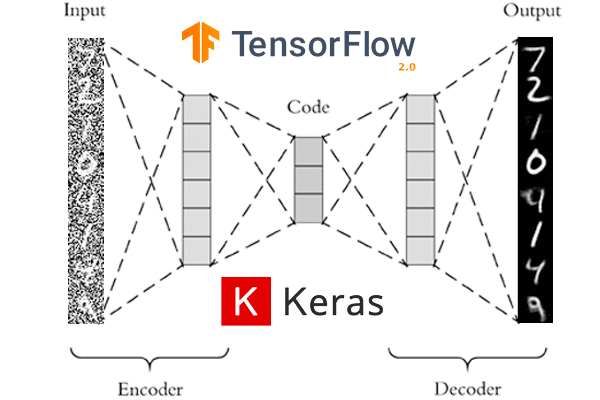


1. Prepare data
2. Define the architecture
3. Train the model
4. Plot Results

##### 1. Prepare Data

In [16]:
# define dataset
X = np.concatenate((eeg_baseline_samples, eeg_playing_samples), axis=0)
y = []
for i in range(len(X)):
    y.append(baseline)
y = np.array(y)

print(f'X shape: {X.shape}, y shape: {y.shape}')

# number of input columns
n_inputs = X.shape[1]

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X shape: (406, 1500), y shape: (406, 1500)
X_train shape: (324, 1500), y_train shape: (324, 1500)
X_test shape: (82, 1500), y_test shape: (82, 1500)


##### 2. Define autoencoder architecture

In [17]:
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 1000
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

##### 3. Train the model

In [18]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/200
21/21 - 4s - loss: 1.3691 - val_loss: 11.9840 - 4s/epoch - 193ms/step
Epoch 2/200
21/21 - 2s - loss: 1.0380 - val_loss: 6.0763 - 2s/epoch - 95ms/step
Epoch 3/200
21/21 - 2s - loss: 0.9029 - val_loss: 2.2499 - 2s/epoch - 97ms/step
Epoch 4/200
21/21 - 2s - loss: 0.7969 - val_loss: 1.3743 - 2s/epoch - 98ms/step
Epoch 5/200
21/21 - 2s - loss: 0.7199 - val_loss: 1.0975 - 2s/epoch - 109ms/step
Epoch 6/200
21/21 - 2s - loss: 0.6612 - val_loss: 1.0205 - 2s/epoch - 105ms/step
Epoch 7/200
21/21 - 2s - loss: 0.6307 - val_loss: 1.0529 - 2s/epoch - 106ms/step
Epoch 8/200
21/21 - 2s - loss: 0.5937 - val_loss: 0.9889 - 2s/epoch - 107ms/step
Epoch 9/200
21/21 - 2s - loss: 0.5556 - val_loss: 0.9564 - 2s/epoch - 106ms/step
Epoch 10/200
21/21 - 2s - loss: 0.5329 - val_loss: 0.9167 - 2s/epoch - 105ms/step
Epoch 11/200
21/21 - 2s - los

##### 4. Plot results

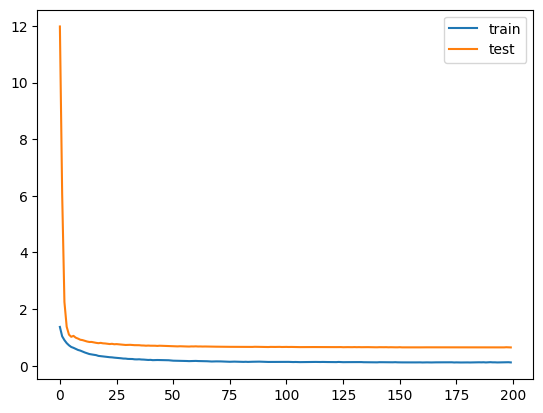

In [19]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
# save the encoder to file
encoder.save('models/denoising_autoencoder.h5')